# Pattern Recognition 2022-23<br>
## Lab3: Genre classification and Emotion recognition in Music<br>

Ηλιόπουλος Γεώργιος: 03118815 <br>
Σερλής Αναστάσιος Εμανουήλ - 03118125<br>
<br>

## Step 0: Familiarization with Kaggle kernels

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa.display
import matplotlib.pyplot as plt
import sys

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

        
#explore subfolders
os.listdir("../input/patreco3-multitask-affective-music/data/")



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/6459.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/7429.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/test/39552.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/23678.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test/39552.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/23678.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/train_labels

['multitask_dataset_beat',
 'fma_genre_spectrograms',
 'fma_genre_spectrograms_beat',
 'multitask_dataset']

## Step 1: Familiarization with spectrograms at the Mel scale

In [2]:
os.listdir("../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/")
with open("../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt") as f:
    lines = f.readlines() #read all lines
    n_lines = len(lines) - 1 # the first line contains headers
    label1 = 'Pop' #randomly selected labels, they are the same in order to start 
    label2= 'Pop'  #the while loop 
    while(label1==label2):  #need to find tracks from different labels
        # randomly choose two lines
        line1 = np.random.randint(1, n_lines)
        line2 = np.random.randint(1, n_lines)
        #split file name from label
        fn1, label1 = lines[line1].split() 
        fn2, label2 = lines[line2].split()       
    print("First file name is:", fn1, "and belongs to the label: ", label1)
    print("Second file name is:", fn2, "and belongs to the label: ", label2)

First file name is: 116451.fused.full.npy.gz and belongs to the label:  Folk
Second file name is: 36191.fused.full.npy.gz and belongs to the label:  Post-Rock


In [3]:
#load actual spectrograms from extracted filenames
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + fn1.strip(".gz"))
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + fn2.strip(".gz"))
#split mel-spectrograms from chromograms
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]
print("Mel-spectrogram shape is:", mel1.shape,"and chromagram shape is:", chroma1.shape)


Mel-spectrogram shape is: (128, 1293) and chromagram shape is: (12, 1293)


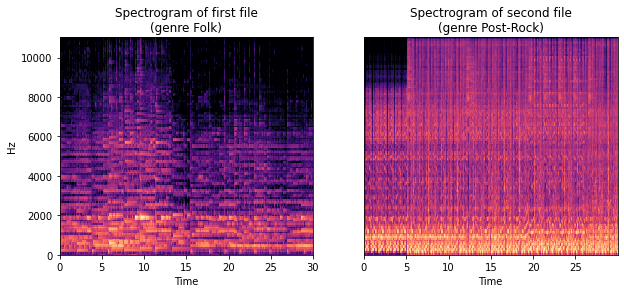

In [4]:
#plot extracted spectrograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Spectrogram of first file\n(genre '+ label1 + ')')
librosa.display.specshow(mel1, x_axis='time', y_axis='linear')
plt.subplot(1, 2, 2)
plt.title('Spectrogram of second file\n(genre '+ label2 + ')')
librosa.display.specshow(mel2, x_axis='time')
plt.show()

## Step 2: Synchronization of the spectrograms to the music beat (beat-synced spectrograms)

In [5]:
#print shapes of used spectrograms
print("Mel-spectrogram shape of first file is:", mel1.shape)
print("Mel-spectrogram shape of second file is:", mel2.shape)
print()
print("Mel-spectrogram time-steps of first file is:", mel1.shape[1])
print("Mel-spectrogram time-steps of second file is:", mel2.shape[1])
#commentary -> too many time steps, which leads to difficulties for an LSTM network
#to effectively include so many features in time-space
#thus, we need to reduce the number of time-steps

Mel-spectrogram shape of first file is: (128, 1293)
Mel-spectrogram shape of second file is: (128, 1291)

Mel-spectrogram time-steps of first file is: 1293
Mel-spectrogram time-steps of second file is: 1291


Mel-spectrogram shape is: (128, 49) and chromagram shape is: (12, 49)


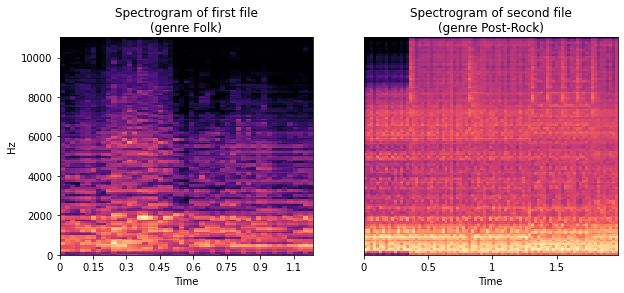

In [6]:
#use median frequencies between time steps for dimension reduction
#same method as step.1

#load actual spectrograms from extracted filenames
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + fn1.strip(".gz"))
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + fn2.strip(".gz"))
#split mel-spectrograms from chromograms
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]
print("Mel-spectrogram shape is:", mel1.shape,"and chromagram shape is:", chroma1.shape)

#plot extracted spectrograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Spectrogram of first file\n(genre '+ label1 + ')')
librosa.display.specshow(mel1, x_axis='time', y_axis='linear')
plt.subplot(1, 2, 2)
plt.title('Spectrogram of second file\n(genre '+ label2 + ')')
librosa.display.specshow(mel2, x_axis='time')
plt.show()


## Step 3: Familiarization with the chromagrams

First file name is: 118623.fused.full.npy.gz and belongs to the label:  Trip-Hop
Second file name is: 10439.fused.full.npy.gz and belongs to the label:  Folk
Mel-spectrogram shape is: (128, 1293) and chromagram shape is: (12, 1293)


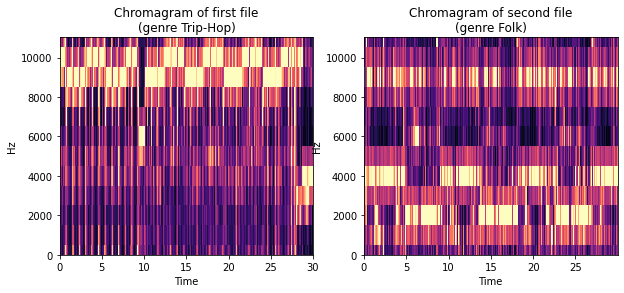

In [7]:
#same as step.1
with open("/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt") as f2:
    lines = f2.readlines() #read all lines
    n_lines = len(lines) - 1 # the first line contains headers
    label1 = 'Pop' #randomly selected labels, they are the same in order to start 
    label2= 'Pop'  #the while loop 
    while(label1==label2):  #need to find tracks from different labels
        # randomly choose two lines
        line1 = np.random.randint(1, n_lines)
        line2 = np.random.randint(1, n_lines)
        #split file name from label
        fn1, label1 = lines[line1].split() 
        fn2, label2 = lines[line2].split()       
    print("First file name is:", fn1, "and belongs to the label: ", label1)
    print("Second file name is:", fn2, "and belongs to the label: ", label2)

#load actual spectrograms from extracted filenames
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + fn1.strip(".gz"))
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + fn2.strip(".gz"))
#split mel-spectrograms from chromograms
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]
print("Mel-spectrogram shape is:", mel1.shape,"and chromagram shape is:", chroma1.shape)

#plot extracted spectrograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Chromagram of first file\n(genre '+ label1 + ')')
librosa.display.specshow(chroma1, x_axis='time', y_axis='linear')
plt.subplot(1, 2, 2)
plt.title('Chromagram of second file\n(genre '+ label2 + ')')
librosa.display.specshow(chroma2, y_axis='linear', x_axis='time')
plt.show()

Mel-spectrogram shape is: (128, 38) and chromagram shape is: (12, 38)


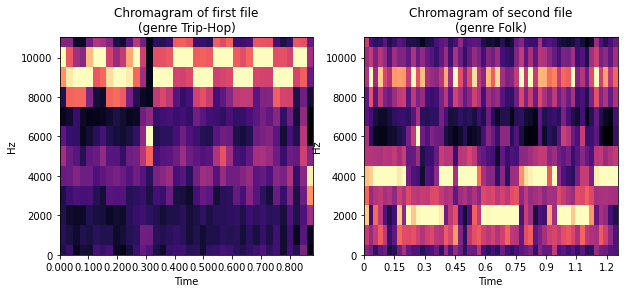

In [8]:
#same as step.2 -> from beat folder
 
#load actual spectrograms from extracted filenames
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + fn1.strip(".gz"))
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + fn2.strip(".gz"))
#split mel-spectrograms from chromograms
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]
print("Mel-spectrogram shape is:", mel1.shape,"and chromagram shape is:", chroma1.shape)

#plot extracted spectrograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Chromagram of first file\n(genre '+ label1 + ')')
librosa.display.specshow(chroma1, x_axis='time', y_axis='linear')
plt.subplot(1, 2, 2)
plt.title('Chromagram of second file\n(genre '+ label2 + ')')
librosa.display.specshow(chroma2, y_axis='linear', x_axis='time')
plt.show()

## Step 4: Data loading and analysis

In [ ]:
#imported code from dataset.py
import copy
import os

import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import re

# HINT: Use this class mapping to merge similar classes and ignore classes that do not work very well
class_mapping = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}

#train-val split function
#about seed -> when it is set to a specific value, it generates the same random sequence each time
#thus leading to the same train-validation split (prefered for debbuging purposes)
#when it is set to 'None', the sequence generated from the input data differs on each call,
#meaning that we end up with different setting for our training (prefered for experimentation/testing of the model)
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_spectrogram(spectrogram_file, chroma=True): #initial function that returns
    # with open(spectrogram_file, "r") as f:         #mel-spectrogram & chromogram   
    spectrograms = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram
    # Decompose as follows
    return spectrograms.T


def read_mel_spectrogram(spectrogram_file): #function that returns mel-spectrogram only
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file): #function that returns chromagram only
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder): #function that encodes the input labels
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])

#function that pads all inputs, in order to have the same length
#it is needed since in some spectrograms, some values are being missed
class PaddingTransform(object): 
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1




class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self, item):
        # Return a tuple in the form (padded_feats, label, length)
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)

### Create a pytorch dataset for mel spectrograms

In [48]:
mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
test_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_mel, batch_size=32)

### Create a pytorch dataset for beat synced mel spectrograms

In [16]:
beat_mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
     
test_beat_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_beat_mel = DataLoader(test_beat_mel, batch_size=32)

#### Create a pytorch dataset for beat synced chromagrams


In [ ]:
beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32 ,32, val_size=.33)

test_beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
test_loader_beat_chroma = DataLoader(test_beat_chroma, batch_size=32)

#### Create a pytorch dataset for chromagrams


In [16]:
chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

train_loader_chroma, val_loader_chroma = torch_train_val_split(chroma, 32 ,32, val_size=.33)

test_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
test_loader_chroma = DataLoader(test_chroma, batch_size=32)

#### Create a pytorch dataset for the fused spectrogram + chromagram for the full (non-beat-synced) data


In [16]:
specs_fused = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)

test = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
test_loader = DataLoader(test, batch_size=32)

#### Making the histograms


In [16]:
#generate datasets with all labels and with merged labels(according to 'CLASS_MAPPING' encoding)
dataset_before = SpectrogramDataset("/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat",
                                               train=True,
                                              )

#extract indicative training and validation sets
train_before, val_before = torch_train_val_split(dataset_before, 32 ,32, val_size=.33)

dataset_after = SpectrogramDataset("/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat",
                                             train=True,
                                             class_mapping=class_mapping,
                                            )

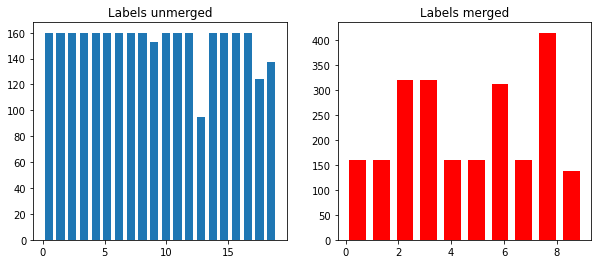

In [17]:
#plot histograms
#labels_unmerged
labels_before = []
for inputs in dataset_before:
    labels_before.append(inputs[1])
    
#labels_merged
labels_after = []
for inputs in dataset_after:
    labels_after.append(inputs[1])
plt.figure(figsize=(10, 4))
#plot extracted spectrograms
plt.subplot(1, 2, 1)
plt.title('Labels unmerged')
plt.hist(labels_before,bins=np.max(labels_before)-np.min(labels_before)+1,rwidth=0.7)
plt.subplot(1, 2, 2)
plt.title('Labels merged')
plt.hist(labels_after,bins=np.max(labels_after)-np.min(labels_after)+1,rwidth=0.7,color='r')
plt.show()

## Step 5: Music genre recognition with LSTM

In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
# sklearn
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

In the below cell we copy and paste the code from lab2 to define, train and evaluate a LSTM model.<br>
The only fix is that we added `.double()` for the tensors `h0` and `c0`.

In [19]:
class BasicLSTM(nn.Module):
    
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False,dropout=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # Initialize the LSTM, Dropout, Output layers
        
        
        self.rnn_size = rnn_size
        self.dropout = dropout
        
        if(self.bidirectional==True):
            self.num_layers=2*num_layers
        else:
            self.num_layers=num_layers
            
        self.lstm = nn.LSTM(input_dim, rnn_size, num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        
        """ 
        Returns LSTM final inferences for all sequences in batch x
        """
        
        # Initialize
        h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).double()
        c0 = h0
        
        lstm_output, _ = self.lstm(x, (h0, c0))
        last_outputs = self.fc(self.last_timestep(lstm_output, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
        Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()



# define a new training function
def train(model, dataloader, criterion, optimizer, overfit_batch=False):    
    tr_loss = 0.0
    model.train()   # train mode
    for i, batch in enumerate(dataloader, 1):
        if overfit_batch:
            inputs, labels, lengths = next(iter(dataloader))
        else:
            inputs, labels, lengths = batch
        optimizer.zero_grad()   # zero gradients out
        y_preds = model(inputs, lengths)    # forward propagate
        loss = criterion(y_preds, labels)   # compute loss function
        loss.backward() # compute gradients
        optimizer.step()    # update parameters

        tr_loss += loss.data.item()

    return tr_loss/i   # train loss


# neural network evaluator
def eval(model, dataloader, criterion, overfit_batch=False):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):
            
            if overfit_batch:
                inputs, labels, lengths = next(iter(dataloader))
            else:
                inputs, labels, lengths = batch
                
            y_preds = model(inputs, lengths) #forward propagate
            loss = criterion(y_preds, labels) #loss function
            pred = torch.argmax(y_preds, dim=1) #make predictions
            
            y_pred.append(pred.numpy()) #get predicted labels
            y_act.append(labels.numpy()) #get real lables

            val_loss += loss.data.item() #add to validation loss

    return val_loss / i, (y_act, y_pred)

**b)** Training a LSTM model in 1 batch to achieve overfitting.<br>
*the LSTM that gets as input the beat-synced spectrograms*

In [32]:
LSTM1 = BasicLSTM(input_dim=128, rnn_size=32, output_dim=10, num_layers=1, bidirectional=False,dropout=0)
LSTM1.double()
opt = torch.optim.Adam(LSTM1.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 2000

for i in range(epochs):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(LSTM1,train_loader_beat_mel,criterion=crit,optimizer=opt, overfit_batch=True)
    temp_val=eval(LSTM1,val_loader_beat_mel,criterion=crit, overfit_batch=True)
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%100 == 0:
        print("Epoch {}:\tTraining Loss = {}\tValidation Loss = {}".format(i, temp_tr,temp_val[0]))
    torch.save(LSTM1, "./LSTM1") # checkpoint

Now running epoch [0/2000]	Epoch 0:	Training Loss = 2.2658914347935464	Validation Loss = 2.2446411750294435
Now running epoch [100/2000]	Epoch 100:	Training Loss = 1.8916018882881134	Validation Loss = 2.0116346562606338
Now running epoch [200/2000]	Epoch 200:	Training Loss = 1.8701349514409562	Validation Loss = 1.9845490837685322
Now running epoch [300/2000]	Epoch 300:	Training Loss = 1.7933958606147957	Validation Loss = 2.000738719241296
Now running epoch [400/2000]	Epoch 400:	Training Loss = 1.8059599310405798	Validation Loss = 2.044596460572888
Now running epoch [500/2000]	Epoch 500:	Training Loss = 1.7951956971208292	Validation Loss = 2.028166724418171
Now running epoch [600/2000]	Epoch 600:	Training Loss = 1.7084710169104096	Validation Loss = 2.0274888217192077
Now running epoch [700/2000]	Epoch 700:	Training Loss = 1.7282085781628373	Validation Loss = 2.11569042286606
Now running epoch [800/2000]	Epoch 800:	Training Loss = 1.699689928669239	Validation Loss = 2.0995816048849982
No

Simple LSTM Accuracies: Validation Set: 27.89473684210526 % -- Test Set: 26.782608695652172 %


ValueError: x and y must have same first dimension, but have shapes (100,) and (101,)

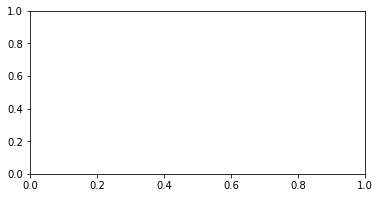

In [41]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader_beat_mel,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader_beat_mel,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Simple LSTM Accuracies: Validation Set: {} % -- Test Set: {} %".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

**c)** LSTM that gets as input the spectrograms of the training set and predicts the
different classes (music genres) of the dataset.

In [50]:
LSTM2 = BasicLSTM(input_dim=128, rnn_size=32, output_dim=10, num_layers=1, bidirectional=False,dropout=0)
LSTM2.double()
model = LSTM2
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 100

print("\033[1m" + "\t\t\t\tSpectrograms" + "\033[0m")

for i in range(epochs+1):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(model,train_loader_mel,criterion=crit,optimizer=opt)
    temp_val=eval(model,val_loader_mel,criterion=crit)
    
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%20 == 0:
        _, (y_train_gold, y_train_pred) = eval(model,train_loader_mel,criterion=crit)
        _, (y_val_gold, y_val_pred) = eval(model,val_loader_mel,criterion=crit)
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("\033[1m" + "Epoch " + str(i) + "\033[0m")
        print("\t\t\t\tTraining Loss = {}".format(temp_tr))
        print("\t\t\t\tValidation Loss = {}".format(temp_val[0]))
        print("\t\t\t\tAccuracy for train: {}".format(accuracy_score(y_train_true, y_train_pred)))
        print("\t\t\t\tAccuracy for validation: {}\n".format(accuracy_score(y_val_true, y_val_pred)))
    torch.save(model, "./LSTM2") # checkpoint

				Spectrograms
Now running epoch [0/100]	Epoch 0
				Training Loss = 2.259853269978605
				Validation Loss = 2.233744937884137
				Accuracy for train: 0.18381877022653723
				Accuracy for validation: 0.18289473684210528

Now running epoch [20/100]	Epoch 20
				Training Loss = 2.177514458459702
				Validation Loss = 2.183713638740623
				Accuracy for train: 0.22524271844660193
				Accuracy for validation: 0.21052631578947367

Now running epoch [40/100]	Epoch 40
				Training Loss = 2.140871974052734
				Validation Loss = 2.2245181132701353
				Accuracy for train: 0.2045307443365696
				Accuracy for validation: 0.1986842105263158

Now running epoch [60/100]	Epoch 60
				Training Loss = 2.129051279572763
				Validation Loss = 2.157626062203359
				Accuracy for train: 0.22330097087378642
				Accuracy for validation: 0.22236842105263158

Now running epoch [80/100]	Epoch 80
				Training Loss = 2.101113994027838
				Validation Loss = 2.1252382632777396
				Accuracy for train: 0.2330097087378

Accuracies:	Validation Set:	22.36842105263158%
		Test Set:	22.782608695652172%



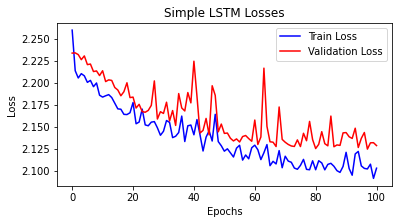

In [51]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader_mel,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader_mel,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Accuracies:\tValidation Set:\t{}%\n\t\tTest Set:\t{}%\n".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs+1),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs+1),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

In [52]:
test_loss, (y_test_gold, y_test_pred) = eval(model,test_loader_mel,criterion=crit)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.19      0.72      0.30        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.27      0.71      0.39       103
           9       0.00      0.00      0.00        34

    accuracy                           0.23       575
   macro avg       0.05      0.14      0.07       575
weighted avg       0.07      0.23      0.11       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**d)** LSTM that gets as input the beat-synced spectrograms of the training set and predicts
the different classes (music genres) of the dataset.

In [40]:
LSTM3 = BasicLSTM(input_dim=128, rnn_size=32, output_dim=10, num_layers=1, bidirectional=False,dropout=0)
LSTM3.double()
model = LSTM3
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 100

print("\033[1m" + "\t\t\t\tBeat-synced spectrograms\n" + "\033[0m")

for i in range(epochs+1):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(model,train_loader_beat_mel,criterion=crit,optimizer=opt)
    temp_val=eval(model,val_loader_beat_mel,criterion=crit)
    
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%20 == 0:
        _, (y_train_gold, y_train_pred) = eval(model,train_loader_beat_mel,criterion=crit)
        _, (y_val_gold, y_val_pred) = eval(model,val_loader_beat_mel,criterion=crit)
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("\033[1m" + "Epoch " + str(i) + "\033[0m")
        print("\t\t\t\tTraining Loss = {}".format(temp_tr))
        print("\t\t\t\tValidation Loss = {}".format(temp_val[0]))
        print("\t\t\t\tAccuracy for train: {}".format(accuracy_score(y_train_true, y_train_pred)))
        print("\t\t\t\tAccuracy for validation: {}\n".format(accuracy_score(y_val_true, y_val_pred)))
    torch.save(model, "./LSTM3") # checkpoint

				Beat-synced spectrograms

Now running epoch [0/100]	Epoch 0
				Training Loss = 2.2610789675760374
				Validation Loss = 2.2435466568042197
				Accuracy for train: 0.143042071197411
				Accuracy for validation: 0.125

Now running epoch [20/100]	Epoch 20
				Training Loss = 2.1093258554623584
				Validation Loss = 2.1173863732398854
				Accuracy for train: 0.24983818770226537
				Accuracy for validation: 0.23157894736842105

Now running epoch [40/100]	Epoch 40
				Training Loss = 2.063218071492715
				Validation Loss = 2.099177519609071
				Accuracy for train: 0.2550161812297735
				Accuracy for validation: 0.23421052631578948

Now running epoch [60/100]	Epoch 60
				Training Loss = 2.0205107004061893
				Validation Loss = 2.058716509190631
				Accuracy for train: 0.2588996763754045
				Accuracy for validation: 0.23684210526315788

Now running epoch [80/100]	Epoch 80
				Training Loss = 1.9922243469339596
				Validation Loss = 2.0626773412584747
				Accuracy for train: 0.27055016181

Accuracies:	Validation Set:	27.89473684210526%
		Test Set:	26.782608695652172%



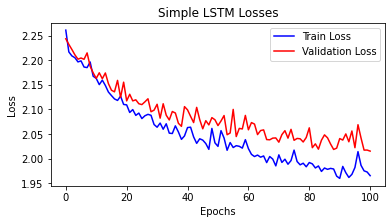

In [47]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader_beat_mel,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader_beat_mel,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Accuracies:\tValidation Set:\t{}%\n\t\tTest Set:\t{}%\n".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs+1),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs+1),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

In [49]:
test_loss, (y_test_gold, y_test_pred) = eval(model,test_loader_beat_mel,criterion=crit)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.17      0.78      0.28        40
           2       0.29      0.46      0.35        80
           3       0.34      0.41      0.37        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.29      0.03      0.05        78
           7       0.00      0.00      0.00        40
           8       0.32      0.50      0.39       103
           9       0.00      0.00      0.00        34

    accuracy                           0.27       575
   macro avg       0.14      0.22      0.14       575
weighted avg       0.19      0.27      0.20       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bideroctional LSTM with dropout (0.2) that gets as input the beat-synced spectrograms of the training set and predicts
the different classes (music genres) of the dataset.

In [20]:
LSTM6 = BasicLSTM(input_dim=128, rnn_size=32, output_dim=10, num_layers=1, bidirectional=True,dropout=0.2)
LSTM6.double()
model = LSTM6
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 100

print("\033[1m" + "\t\t\t\tBeat-synced spectrograms\n" + "\033[0m")

for i in range(epochs+1):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(model,train_loader_beat_mel,criterion=crit,optimizer=opt)
    temp_val=eval(model,val_loader_beat_mel,criterion=crit)
    
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%20 == 0:
        _, (y_train_gold, y_train_pred) = eval(model,train_loader_beat_mel,criterion=crit)
        _, (y_val_gold, y_val_pred) = eval(model,val_loader_beat_mel,criterion=crit)
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("\033[1m" + "Epoch " + str(i) + "\033[0m")
        print("\t\t\t\tTraining Loss = {}".format(temp_tr))
        print("\t\t\t\tValidation Loss = {}".format(temp_val[0]))
        print("\t\t\t\tAccuracy for train: {}".format(accuracy_score(y_train_true, y_train_pred)))
        print("\t\t\t\tAccuracy for validation: {}\n".format(accuracy_score(y_val_true, y_val_pred)))
    torch.save(model, "./LSTM6") # checkpoint

				Beat-synced spectrograms

Now running epoch [0/100]	

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
				Training Loss = 2.2463703813417597
				Validation Loss = 2.2005070754272826
				Accuracy for train: 0.18576051779935276
				Accuracy for validation: 0.20526315789473684

Now running epoch [20/100]	Epoch 20
				Training Loss = 2.111567854703567
				Validation Loss = 2.072138848931998
				Accuracy for train: 0.2336569579288026
				Accuracy for validation: 0.24473684210526317

Now running epoch [40/100]	Epoch 40
				Training Loss = 2.0411269291962473
				Validation Loss = 2.018732840001739
				Accuracy for train: 0.26537216828478966
				Accuracy for validation: 0.24605263157894736

Now running epoch [60/100]	Epoch 60
				Training Loss = 2.0188279666726987
				Validation Loss = 2.0391481382388115
				Accuracy for train: 0.255663430420712
				Accuracy for validation: 0.2894736842105263

Now running epoch [80/100]	Epoch 80
				Training Loss = 1.984962967366613
				Validation Loss = 1.9882878471382792
				Accuracy for train: 0.3042071197411003
				Accuracy for validation: 0.265789

Accuracies:	Validation Set:	27.76315789473684%
		Test Set:	28.000000000000004%



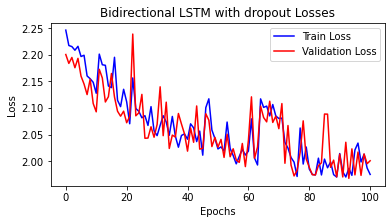

In [21]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader_beat_mel,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader_beat_mel,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Accuracies:\tValidation Set:\t{}%\n\t\tTest Set:\t{}%\n".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs+1),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs+1),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Bidirectional LSTM with dropout Losses')
plt.show()

In [22]:
test_loss, (y_test_gold, y_test_pred) = eval(model,test_loader_beat_mel,criterion=crit)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.21      0.65      0.31        40
           2       0.26      0.61      0.36        80
           3       0.27      0.25      0.26        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.42      0.40      0.41        78
           7       0.00      0.00      0.00        40
           8       0.32      0.34      0.33       103
           9       0.00      0.00      0.00        34

    accuracy                           0.28       575
   macro avg       0.15      0.22      0.17       575
weighted avg       0.20      0.28      0.22       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**e)** LSTM that gets as input the chromagrams of the training set and predicts
the different classes (music genres) of the dataset.

In [22]:
LSTM4 = BasicLSTM(input_dim=12, rnn_size=32, output_dim=10, num_layers=1, bidirectional=False,dropout=0)
LSTM4.double()
model = LSTM4
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 100

print("\033[1m" + "\t\t\t\tChromagrams\n" + "\033[0m")

for i in range(epochs+1):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(model,train_loader_chroma,criterion=crit,optimizer=opt)
    temp_val=eval(model,val_loader_chroma,criterion=crit)
    
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%20 == 0:
        _, (y_train_gold, y_train_pred) = eval(model,train_loader_chroma,criterion=crit)
        _, (y_val_gold, y_val_pred) = eval(model,val_loader_chroma,criterion=crit)
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("\033[1m" + "Epoch " + str(i) + "\033[0m")
        print("\t\t\t\tTraining Loss = {}".format(temp_tr))
        print("\t\t\t\tValidation Loss = {}".format(temp_val[0]))
        print("\t\t\t\tAccuracy for train: {}".format(accuracy_score(y_train_true, y_train_pred)))
        print("\t\t\t\tAccuracy for validation: {}\n".format(accuracy_score(y_val_true, y_val_pred)))
    torch.save(model, "./LSTM4") # checkpoint

				Chromagrams

Now running epoch [0/100]	Epoch 0
				Training Loss = 2.2632615550528867
				Validation Loss = 2.2155961849940136
				Accuracy for train: 0.1650485436893204
				Accuracy for validation: 0.19473684210526315

Now running epoch [20/100]	Epoch 20
				Training Loss = 2.2101346988328143
				Validation Loss = 2.1967215652445247
				Accuracy for train: 0.18576051779935276
				Accuracy for validation: 0.19210526315789472

Now running epoch [40/100]	Epoch 40
				Training Loss = 2.1667629183486063
				Validation Loss = 2.1818120712456204
				Accuracy for train: 0.20841423948220064
				Accuracy for validation: 0.21052631578947367

Now running epoch [60/100]	Epoch 60
				Training Loss = 2.111970337592904
				Validation Loss = 2.189674625724541
				Accuracy for train: 0.2284789644012945
				Accuracy for validation: 0.16842105263157894

Now running epoch [80/100]	Epoch 80
				Training Loss = 2.1217558872204756
				Validation Loss = 2.2181184848555
				Accuracy for train: 0.2504854368

Accuracies:	Validation Set:	19.342105263157894%
		Test Set:	18.434782608695652%



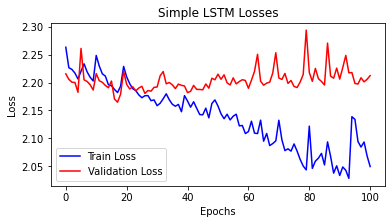

In [23]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader_chroma,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader_chroma,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Accuracies:\tValidation Set:\t{}%\n\t\tTest Set:\t{}%\n".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs+1),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs+1),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

In [24]:
test_loss, (y_test_gold, y_test_pred) = eval(model,test_loader_chroma,criterion=crit)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.14      0.07      0.10        40
           1       0.16      0.20      0.18        40
           2       0.13      0.15      0.14        80
           3       0.19      0.31      0.23        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.23      0.31      0.26        78
           7       0.00      0.00      0.00        40
           8       0.22      0.31      0.26       103
           9       0.08      0.06      0.07        34

    accuracy                           0.18       575
   macro avg       0.12      0.14      0.12       575
weighted avg       0.14      0.18      0.16       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**f)** LSTM that gets as input the concatenated chromagrams and
spectrograms of the training set and predicts the different classes (music genres) of the dataset.

In [19]:
LSTM5 = BasicLSTM(input_dim=140, rnn_size=32, output_dim=10, num_layers=1, bidirectional=False,dropout=0)
LSTM5.double()
model = LSTM5
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]

crit = nn.CrossEntropyLoss()

epochs = 100

print("\033[1m" + "\t\t\t\tConcatenated chromagrams and spectrograms\n" + "\033[0m")

for i in range(epochs+1):
    sys.stdout.write('\r')
    sys.stdout.write("Now running epoch [{}/{}]\t".format(i,epochs))
    sys.stdout.flush()
    temp_tr=train(model,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval(model,val_loader,criterion=crit)
    
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    if i%20 == 0:
        _, (y_train_gold, y_train_pred) = eval(model,train_loader,criterion=crit)
        _, (y_val_gold, y_val_pred) = eval(model,val_loader,criterion=crit)
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("\033[1m" + "Epoch " + str(i) + "\033[0m")
        print("\t\t\t\tTraining Loss = {}".format(temp_tr))
        print("\t\t\t\tValidation Loss = {}".format(temp_val[0]))
        print("\t\t\t\tAccuracy for train: {}".format(accuracy_score(y_train_true, y_train_pred)))
        print("\t\t\t\tAccuracy for validation: {}\n".format(accuracy_score(y_val_true, y_val_pred)))
    torch.save(model, "./LSTM5") # checkpoint

				Concatenated chromagrams and spectrograms

Now running epoch [0/100]	Epoch 0
				Training Loss = 2.2480127529051237
				Validation Loss = 2.22454630073958
				Accuracy for train: 0.1779935275080906
				Accuracy for validation: 0.18289473684210528

Now running epoch [20/100]	Epoch 20
				Training Loss = 2.189653765142124
				Validation Loss = 2.2021772311189
				Accuracy for train: 0.1779935275080906
				Accuracy for validation: 0.18421052631578946

Now running epoch [40/100]	Epoch 40
				Training Loss = 2.1591091389893053
				Validation Loss = 2.180831263132415
				Accuracy for train: 0.20776699029126214
				Accuracy for validation: 0.2013157894736842

Now running epoch [60/100]	Epoch 60
				Training Loss = 2.137871768504848
				Validation Loss = 2.1606475173472814
				Accuracy for train: 0.2174757281553398
				Accuracy for validation: 0.2013157894736842

Now running epoch [80/100]	Epoch 80
				Training Loss = 2.121783518436231
				Validation Loss = 2.151667592018876
				Accuracy f

Accuracies:	Validation Set:	19.736842105263158%
		Test Set:	20.347826086956523%



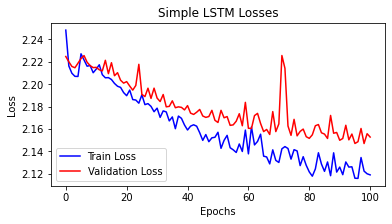

In [20]:
#print losses and accuracies of model
_,(val_real_1,val_1)=eval(model,val_loader,criterion=crit)
_,(test_real_1,test_1)=eval(model,test_loader,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Accuracies:\tValidation Set:\t{}%\n\t\tTest Set:\t{}%\n".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs+1),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs+1),val_arr_1,label='Validation Loss',color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

In [21]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_3(model10,"CNN10",val_loader_10,crit=UnitedLoss(),device=DEVICE,overfit_batch=False)test_loss, (y_test_gold, y_test_pred) = eval(model,test_loader,criterion=crit)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.16      0.74      0.26        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.28      0.56      0.37       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.04      0.13      0.06       575
weighted avg       0.07      0.20      0.10       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>## ===== End of Pre-Lab ======

>## ==== Start of Main Lab ====

In [3]:
import copy
import os

import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

# HINT: Use this class mapping to merge similar classes and ignore classes that do not work very well
CLASS_MAPPING = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}


def torch_train_val_split(
    dataset, batch_train, batch_eval, val_size=0.2, shuffle=True, seed=420
):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_eval, sampler=val_sampler)
    return train_loader, val_loader


def read_spectrogram(spectrogram_file, feat_type):
    spectrogram = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram
    
    if feat_type=='mel':
        return spectrogram[:128, :].T
    elif feat_type=='chroma':
        return spectrogram[128:, :].T

    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1


class SpectrogramDataset(Dataset):
    def __init__(
        self, path, class_mapping=None, train=True, feat_type='mel', max_length=-1, regression=None
    ):
        t = "train" if train else "test"
        p = os.path.join(path, t)
        self.regression = regression

        self.full_path = p
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f), feat_type) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            if not regression:
                self.labels = np.array(
                    self.label_transformer.fit_transform(labels)
                ).astype("int64")
            else:
                self.labels = np.array(labels).astype("float64")

    def get_files_labels(self, txt, class_mapping):
        with open(txt, "r") as fd:
            lines = [l.rstrip().split("\t") for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:            
            if self.regression:
                l = l[0].split(",")
                files.append(l[0] + ".fused.full.npy")
                labels.append(l[self.regression])
                continue
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            fname = l[0]
            if fname.endswith(".gz"):
                fname = ".".join(fname.split(".")[:-1])
            
            if 'fma_genre_spectrograms_beat' in self.full_path.split('/'): # necessary fix 1
                fname = fname.replace('beatsync.fused', 'fused.full')            
            if 'test' in self.full_path.split('/'): # necessary fix 2
                fname = fname.replace('full.fused', 'fused.full')
            
            files.append(fname)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)

In [4]:
# copy paste from convolution.py and add the implementation
import torch
import torch.nn as nn

class CNNBackbone(nn.Module):
    def __init__(self, input_dims, in_channels, filters, feature_size):
        super(CNNBackbone, self).__init__()
        self.input_dims = input_dims
        self.in_channels = in_channels
        self.filters = filters
        self.feature_size = feature_size
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, filters[0], kernel_size=(5,5), stride=1, padding=2),
            nn.BatchNorm2d((self.in_channels**1) * filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv2 = nn.Sequential(
                nn.Conv2d(filters[0], filters[1], kernel_size=(5,5), stride=1, padding=2),
                nn.BatchNorm2d((self.in_channels**2) * filters[1]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv3 = nn.Sequential(
                nn.Conv2d(filters[1], filters[2], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**3) * filters[2]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv4 = nn.Sequential(
                nn.Conv2d(filters[2], filters[3], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**4) * filters[3]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        
        shape_after_convs = [input_dims[0]//2**(len(filters)), input_dims[1]//2**(len(filters))]
        self.fc1 = nn.Linear(filters[3] * shape_after_convs[0] * shape_after_convs[1], self.feature_size)
        
    def forward(self, x):
        x = x.view(x.shape[0], self.in_channels, x.shape[1], x.shape[2])
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [5]:
#classifier & regressor
def load_backbone_from_checkpoint(model, checkpoint_path):
    return model.load_state_dict(torch.load(checkpoint_path))

class Classifier(nn.Module):
    def __init__(self, num_classes, backbone, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        num_classes (int): The number of classes
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Classifier, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
#         self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()  # Loss function for classification

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) 
#         if not self.is_lstm else self.backbone(x, lengths)
        logits = self.output_layer(feats)
        loss = self.criterion(logits, targets)
        return loss, logits
    
    def flush(self):
        pass

class Regressor(nn.Module):
    def __init__(self, backbone, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Regressor, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, 1)
        self.criterion = nn.MSELoss()  # Loss function for regression

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) if not self.is_lstm else self.backbone(x, lengths)
        out = self.output_layer(feats)
        loss = self.criterion(out.float(), targets.float())
        return loss, out


In [14]:
# training + early stopping + overfit

def overfit_with_a_couple_of_batches(model, train_loader,val_loader, optimizer, epochs, device, quest_nine_=False):
    print('Training in overfitting mode...')
    train_arr=[]
    val_arr=[]
    # get only the 1st batch
    x_b1, y_b1, lengths_b1 = next(iter(train_loader))    
    x_b2, y_b2, lengths_b2 = next(iter(val_loader))
    if(quest_nine_):
        y_b1 = y_b1.float().to(device)
    else:
        y_b1 = y_b1.to(device)
    for epoch in range(epochs): 
        model.train()
        loss, logits = model(x_b1.float().to(device), y_b1, lengths_b1.to(device))
        # prepare
        optimizer.zero_grad()
        # backward
        loss.backward()
        # optimizer step
        optimizer.step()
        #validation loss
        model.eval()
        loss2,logits2=model(x_b2.float().to(device), y_b2.to(device), lengths_b2.to(device))
        train_arr.append(loss.item())
        val_arr.append(loss2.item())
        if epoch == 0 or (epoch+1)%20 == 0:
            print("batch shapes are: ",np.shape(x_b1), "and",np.shape(x_b2))
            print(f'Epoch {epoch+1}, Loss at training set: {loss.item()}\n\tLoss at validation set: {loss2.item()}')
    return train_arr,val_arr    

def train_one_epoch(model, train_loader, optimizer, device="cuda",quest_nine_=False):
    model.train()
    total_loss = 0
    for x, y, lengths in train_loader:        
        if(quest_nine_):
            y = y.float().to(device)
        else:
            y= y.to(device)
        loss, logits = model(x.float().to(device), y, lengths.to(device))
        # prepare
        optimizer.zero_grad()
        # backward
        loss.backward()
        # optimizer step
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)    
    return avg_loss


def validate_one_epoch(model, val_loader, device="cuda",quest_nine_=False):    
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y, lengths in val_loader:
            if (quest_nine_):
                y=y.float().to(device)
            else:
                y=y.to(device)
            loss, logits = model(x.float().to(device), y, lengths.to(device))
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)    
    return avg_loss


def train(model,model_name,train_loader, val_loader, optimizer, epochs, save_path='checkpoint.pth', device="cuda", overfit_batch=False,quest_nine=False):
    if overfit_batch:
        train_arr_over,val_arr_over=overfit_with_a_couple_of_batches(model, train_loader, val_loader, optimizer, epochs, device,quest_nine_=quest_nine)
        torch.save(model.state_dict(), model_name)
        return train_arr_over,val_arr_over 
    else:
        print(f'Training started for model {save_path.replace(".pth", "")}...')
        early_stopper = EarlyStopper(model, model_name, patience=5)
        train_arr=[]
        val_arr=[]
        for epoch in range(epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer,quest_nine_=quest_nine)
            validation_loss = validate_one_epoch(model, val_loader,quest_nine_=quest_nine)
            train_arr.append(train_loss)
            val_arr.append(validation_loss)
            if epoch== 0 or (epoch+1)%5==0:
                print(f'Epoch {epoch+1}/{epochs}, Loss at training set: {train_loss}\n\tLoss at validation set: {validation_loss}')          
            if early_stopper.early_stop(validation_loss):
                torch.save(model.state_dict(), model_name)
                print('Early Stopping was activated.')
                print(f'Epoch {epoch+1}/{epochs}, Loss at training set: {train_loss}\n\tLoss at validation set: {validation_loss}')
                print('Training has been completed.\n')
                break
        torch.save(model.state_dict(), model_name)
        return train_arr,val_arr

class EarlyStopper:
    def __init__(self, model,model_name, patience=5, min_delta=0):
        self.model = model
        self.model_name = model_name
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(self.model.state_dict(), self.model_name)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Step 7: 2D CNN

In [15]:
from sklearn.metrics import classification_report
def eval(model,model_name,dataloader, crit, device="cuda",overfit_batch=False):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.load_state_dict(torch.load(model_name))
#     print(model.parameters())
    criterion=crit
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):    
            if overfit_batch:
                inputs, labels, lengths = next(iter(dataloader))
            else:
                inputs, labels, lengths = batch
                
            loss, y_preds = model(inputs.float().to(device), labels.to(device), lengths.to(device))
            pred = torch.argmax(y_preds, dim=1) #make predictions
            y_pred.append(pred.cpu().numpy()) #get predicted labels
            y_act.append(labels.cpu().numpy()) #get real lables
    y_act=np.concatenate(y_act).ravel()
    y_pred=np.concatenate(y_pred).ravel()
    print(classification_report(y_act,y_pred))
    return val_loss / i, y_act, y_pred

In [8]:
# dataloaders for specific features type, e.g. 'mel'
BATCH_SIZE = 32
MAX_LENGTH = -1
DEVICE = 'cuda'

PARENT_DATA_DIR = '../input/patreco3-multitask-affective-music/data/'

train_dataset = SpectrogramDataset(
    os.path.join(PARENT_DATA_DIR, 'fma_genre_spectrograms'), class_mapping=CLASS_MAPPING, 
    train=True, feat_type='mel', max_length=MAX_LENGTH
)

train_loader, val_loader = torch_train_val_split(
    train_dataset, BATCH_SIZE, BATCH_SIZE
)

test_dataset = SpectrogramDataset(
    os.path.join(PARENT_DATA_DIR, 'fma_genre_spectrograms'), class_mapping=CLASS_MAPPING, 
    train=False, feat_type='mel', max_length=MAX_LENGTH
)

test_loader = DataLoader(test_dataset, batch_size=32)


In [12]:
# run Training in overfitting mode for the CNN 
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 50

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_loader))
input_shape = x_b1[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(NUM_CATEGORIES, backbone)
print(model)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

arr1,arr2=train(model,"CNN7",train_loader, val_loader, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=False)
 

Classifier(
  (backbone): CNNBackbone(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256

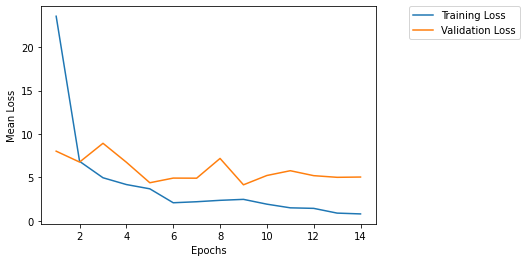

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        40
           1       0.50      0.42      0.46        40
           2       0.76      0.28      0.40        80
           3       0.38      0.47      0.42        80
           4       0.42      0.57      0.48        40
           5       0.14      0.17      0.16        40
           6       0.40      0.76      0.52        78
           7       0.15      0.33      0.20        40
           8       0.24      0.11      0.15       103
           9       0.32      0.24      0.27        34

    accuracy                           0.35       575
   macro avg       0.38      0.34      0.31       575
weighted avg       0.39      0.35      0.32       575



In [13]:
#plot results
import matplotlib.pyplot as plt
# print("mean losses are: ",arr1," ",arr2)
epochs_=np.linspace(1,np.shape(arr1)[0],np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1,a2,a3=eval(model,"CNN7",test_loader,crit=nn.CrossEntropyLoss(),device=DEVICE,overfit_batch=False)



## Step 8: Emotion - Behavior estimation with regression

In [9]:
# A full LSTM implementation is provided
# You can use this or the one you implemented in the second lab

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PadPackedSequence(nn.Module):
    def __init__(self):
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PadPackedSequence, self).__init__()
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first=self.batch_first, total_length=self.max_length  # type: ignore
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out


class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=4,
        bidirectional=False,
        dropout=0.1,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        return last_timestep

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out

In [10]:
from sklearn.metrics import classification_report
def eval_2(model,model_name,dataloader, crit, device="cuda",overfit_batch=False):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.load_state_dict(torch.load(model_name))
#     print(model.parameters())
    criterion=crit
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):    
            if overfit_batch:
                inputs, labels, lengths = next(iter(dataloader))
            else:
                inputs, labels, lengths = batch
            loss, y_preds = model(inputs.float().to(device), labels.to(device), lengths.to(device))
            pred = y_preds
            y_pred.append(pred.cpu().numpy()) #get predicted labels
            y_act.append(labels.cpu().numpy()) #get real lables
    y_pred=np.array(y_pred)
    y_act=np.array(y_act)
    print(y_pred.shape,y_act.shape)
    rho= scipy.stats.spearmanr(np.array(y_act).flatten(),np.array(y_pred).flatten()).correlation
    print("Spearman Correlation is: ",rho)
    
    true = np.array(y_act).flatten()
    pred = np.array(y_pred).flatten()
    
    # Scatter Plot Predictions - Gold Labels
    plt.figure(figsize=(6,6))
    plt.scatter(true, pred)
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    golden_line = np.linspace(-1,1,1000)
    plt.plot(golden_line,golden_line, '-', color='k')
    plt.title("LSTM + Energy")
    plt.show()
    return rho

In [11]:
# dataloaders for specific features type, e.g. 'mel'
BATCH_SIZE = 32
MAX_LENGTH = -1
DEVICE = 'cuda'

PARENT_DATA_DIR = '../input/patreco3-multitask-affective-music/data/'

train_dataset_1=SpectrogramDataset(
    os.path.join(PARENT_DATA_DIR, 'multitask_dataset'), class_mapping=CLASS_MAPPING, 
    train=True, max_length=MAX_LENGTH, regression=1
)

train_loader_1,val_loader_1 = torch_train_val_split(
    train_dataset_1, BATCH_SIZE, BATCH_SIZE )
    
train_dataset_2=SpectrogramDataset(
    os.path.join(PARENT_DATA_DIR, 'multitask_dataset'), class_mapping=CLASS_MAPPING, 
    train=True, max_length=MAX_LENGTH, regression=2
)

train_loader_2,val_loader_2 = torch_train_val_split(
    train_dataset_2, BATCH_SIZE, BATCH_SIZE)
    
train_dataset_3=SpectrogramDataset(
    os.path.join(PARENT_DATA_DIR, 'multitask_dataset'), class_mapping=CLASS_MAPPING, 
    train=True, max_length=MAX_LENGTH, regression=3
)

train_loader_3,val_loader_3 = torch_train_val_split(
    train_dataset_3, BATCH_SIZE, BATCH_SIZE)

Training started for model checkpoint...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss at training set: 5076.105546850583
	Loss at validation set: 273.19573974609375
Epoch 5/100, Loss at training set: 1.6635443208546474
	Loss at validation set: 1.2154825159481593
Epoch 10/100, Loss at training set: 0.46098586197557123
	Loss at validation set: 0.44206225872039795
Epoch 15/100, Loss at training set: 0.24042280326629506
	Loss at validation set: 0.2609427124261856
Epoch 20/100, Loss at training set: 0.21525660003053732
	Loss at validation set: 0.18281696736812592
Epoch 25/100, Loss at training set: 0.23368539789627338
	Loss at validation set: 0.13475104527814047
Epoch 30/100, Loss at training set: 0.1364934344230027
	Loss at validation set: 0.20136176688330515
Early Stopping was activated.
Epoch 30/100, Loss at training set: 0.1364934344230027
	Loss at validation set: 0.20136176688330515
Training has been completed.



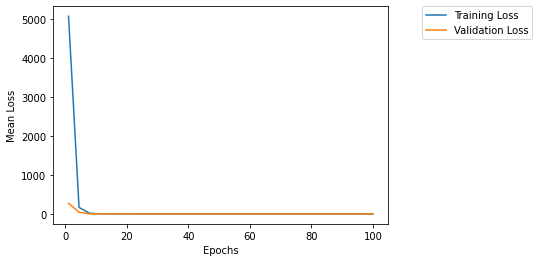

Spearman Correlation is:  0.02775698729408194


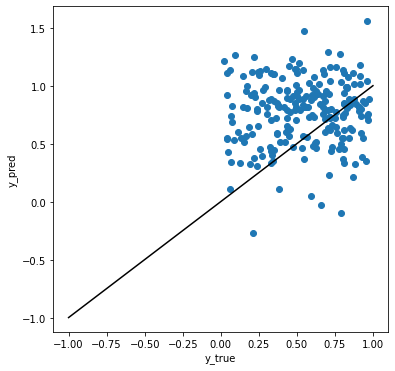

In [20]:
# CNN+valence
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 100

# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_1))
input_shape = x_b[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model_8_1 = Regressor(backbone,load_from_checkpoint=None)
model_8_1.to(DEVICE)

optimizer = torch.optim.Adam(model_8_1.parameters(), lr=LR)

arr1,arr2=train(model_8_1,"CNN8.1",train_loader_1, val_loader_1, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=False)

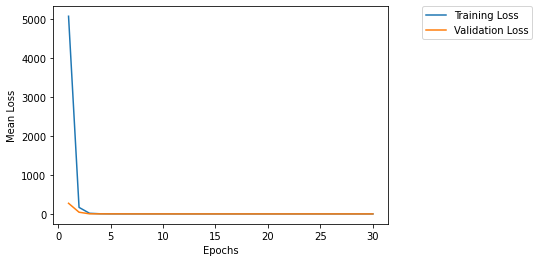

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Spearman Correlation is:  0.02775698729408194


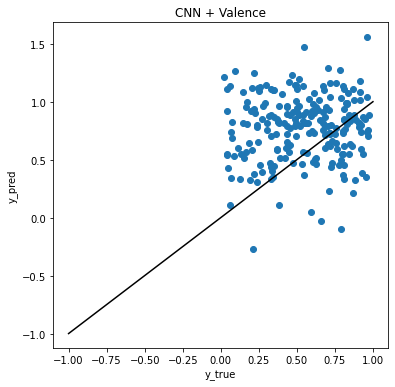

In [23]:
epochs_=np.linspace(1,np.shape(arr1)[0],np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_1,"CNN8.1",val_loader_1,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

In [24]:
#LSTM+valence
DEVICE = 'cuda' 
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 10

LR = 1e-4
epochs = 100
# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_1))
input_shape = x_b[0].shape

backbone = LSTMBackbone(input_shape[1], rnn_size=RNN_HIDDEN_SIZE, num_layers=3, bidirectional=True)
model_8_2 = Regressor(backbone)
model_8_2.to(DEVICE)

optimizer = torch.optim.Adam(model_8_2.parameters(), lr=LR)

arr1,arr2=train(model_8_2,"LSTM8.1",train_loader_1, val_loader_1, optimizer, epochs, device=DEVICE, overfit_batch=False, quest_nine=False)

Training started for model checkpoint...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss at training set: 0.18651611601998067
	Loss at validation set: 0.07162331842950412
Epoch 5/100, Loss at training set: 0.06747972618403106
	Loss at validation set: 0.06856139908943858
Early Stopping was activated.
Epoch 7/100, Loss at training set: 0.06777059800665954
	Loss at validation set: 0.06863199706588473
Training has been completed.



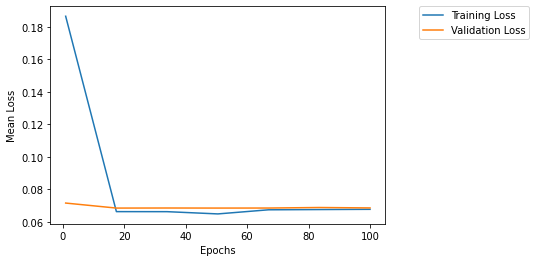

Spearman Correlation is:  0.08645484218039379


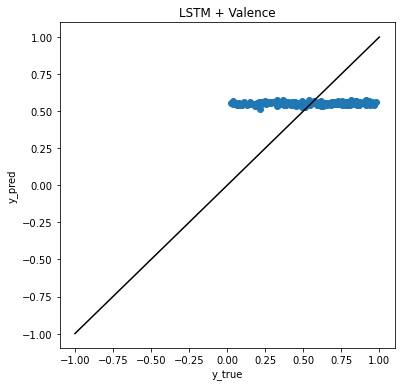

In [28]:
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_2,"LSTM8.1",val_loader_1,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

In [18]:
# CNN+energy
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 100

# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_2))
input_shape = x_b[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model_8_3 = Regressor(backbone,load_from_checkpoint=None)
model_8_3.to(DEVICE)

optimizer = torch.optim.Adam(model_8_3.parameters(), lr=LR)

arr1,arr2=train(model_8_3,"CNN8.2",train_loader_2, val_loader_2, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=False)

Training started for model checkpoint...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss at training set: 3764.5790320162114
	Loss at validation set: 312.70800345284596
Epoch 5/100, Loss at training set: 0.6651467382907867
	Loss at validation set: 0.4568645400660379
Epoch 10/100, Loss at training set: 0.28662164868979617
	Loss at validation set: 0.16193958904061997
Epoch 15/100, Loss at training set: 0.19046166076742369
	Loss at validation set: 0.15391971596649714
Epoch 20/100, Loss at training set: 0.16176532799827642
	Loss at validation set: 0.09939591480152947
Epoch 25/100, Loss at training set: 0.13692211051439418
	Loss at validation set: 0.09507270583084651
Epoch 30/100, Loss at training set: 0.12005556400479941
	Loss at validation set: 0.18031094755445207
Epoch 35/100, Loss at training set: 0.10052814463089252
	Loss at validation set: 0.08166098009262766
Epoch 40/100, Loss at training set: 0.09869503223433576
	Loss at validation set: 0.08703359535762242
Epoch 45/100, Loss at training set: 0.10264873401872043
	Loss at validation set: 0.08694685144083

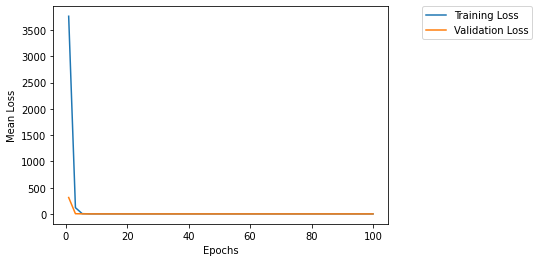

(7, 32, 1) (7, 32)
Spearman Correlation is:  -0.025495086042851077


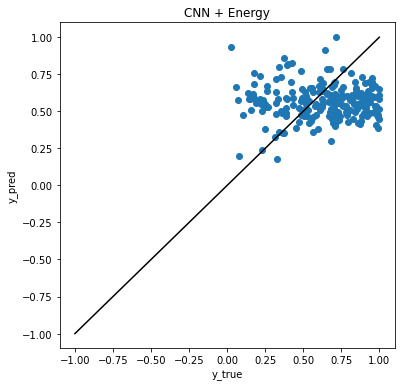

In [22]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_3,"CNN8.2",val_loader_2,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

In [12]:
#LSTM+energy
DEVICE = 'cuda' 
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 10

LR = 1e-4
epochs = 100
# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_2))
input_shape = x_b[0].shape

backbone = LSTMBackbone(input_shape[1], rnn_size=RNN_HIDDEN_SIZE, num_layers=3, bidirectional=True)
model_8_4 = Regressor(backbone)
model_8_4.to(DEVICE)

optimizer = torch.optim.Adam(model_8_4.parameters(), lr=LR)

arr1,arr2=train(model_8_4,"LSTM8.2",train_loader_2, val_loader_2, optimizer, epochs, device=DEVICE, overfit_batch=False, quest_nine=False)

Training started for model checkpoint...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss at training set: 0.2138788271053084
	Loss at validation set: 0.06955899990030698
Epoch 5/100, Loss at training set: 0.07167180216517942
	Loss at validation set: 0.06206994929483959
Epoch 10/100, Loss at training set: 0.06825736755954809
	Loss at validation set: 0.06220170323337827
Early Stopping was activated.
Epoch 10/100, Loss at training set: 0.06825736755954809
	Loss at validation set: 0.06220170323337827
Training has been completed.



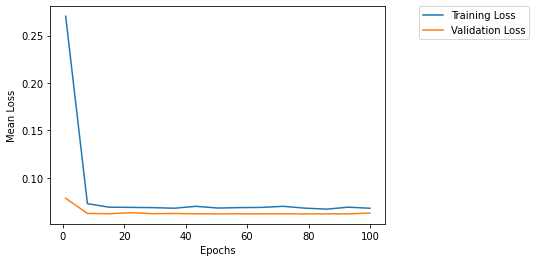

(7, 32, 1) (7, 32)
Spearman Correlation is:  0.2226982980129728


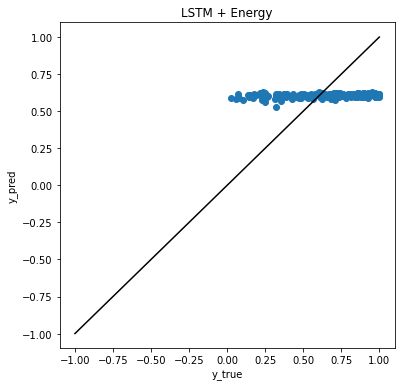

In [26]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_4,"LSTM8.2",val_loader_2,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

In [13]:
# CNN+danceability
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 100

# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_3))
input_shape = x_b[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model_8_5 = Regressor(backbone,load_from_checkpoint=None)
model_8_5.to(DEVICE)

optimizer = torch.optim.Adam(model_8_5.parameters(), lr=LR)

arr1,arr2=train(model_8_5,"CNN8.3",train_loader_3, val_loader_3, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=False)

Training started for model checkpoint...
Epoch 1/100, Loss at training set: 5326.149591123236
	Loss at validation set: 287.80330548967635
Epoch 5/100, Loss at training set: 1.4637093872859561
	Loss at validation set: 0.8894638334001813
Epoch 10/100, Loss at training set: 0.4277674802418413
	Loss at validation set: 0.33509279787540436
Epoch 15/100, Loss at training set: 0.29612600238158787
	Loss at validation set: 0.20974638845239366
Epoch 20/100, Loss at training set: 0.16122552187278352
	Loss at validation set: 0.10847507523638862
Epoch 25/100, Loss at training set: 0.16052848408962117
	Loss at validation set: 0.1415452935865947
Early Stopping was activated.
Epoch 25/100, Loss at training set: 0.16052848408962117
	Loss at validation set: 0.1415452935865947
Training has been completed.



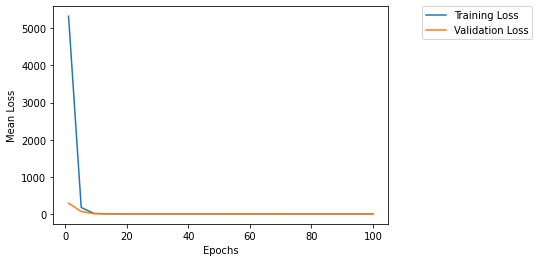

Spearman Correlation is:  0.0040412679121467005


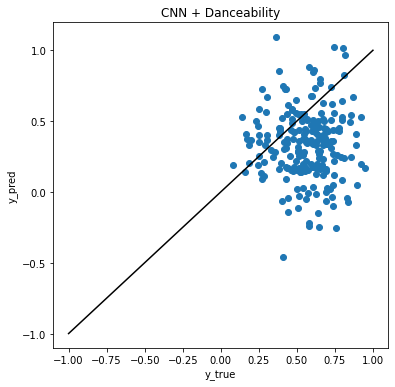

In [14]:
from sklearn.metrics import classification_report
def eval_2(model,model_name,dataloader, crit, device="cuda",overfit_batch=False):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.load_state_dict(torch.load(model_name))
#     print(model.parameters())
    criterion=crit
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):    
            if overfit_batch:
                inputs, labels, lengths = next(iter(dataloader))
            else:
                inputs, labels, lengths = batch
            loss, y_preds = model(inputs.float().to(device), labels.to(device), lengths.to(device))
            pred = y_preds
            y_pred.append(pred.cpu().numpy()) #get predicted labels
            y_act.append(labels.cpu().numpy()) #get real lables
    y_pred=np.array(y_pred)
    y_act=np.array(y_act)
    
#     print(np.shape(np.squeeze(y_pred)),np.shape(y_act))
#     print(np.squeeze(y_pred),y_act)
    rho= scipy.stats.spearmanr(np.array(y_act).flatten(),np.array(y_pred).flatten()).correlation
    print("Spearman Correlation is: ",rho)
    
    true = np.array(y_act).flatten()
    pred = np.array(y_pred).flatten()
    
    # Scatter Plot Predictions - Gold Labels
    plt.figure(figsize=(6,6))
    plt.scatter(true, pred)
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    golden_line = np.linspace(-1,1,1000)
    plt.plot(golden_line,golden_line, '-', color='k')
    plt.title("CNN + Danceability") #changes each time
    plt.show()
    return rho

import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_5,"CNN8.3",val_loader_3,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

In [29]:
#LSTM+danceability
DEVICE = 'cuda' 
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 10

LR = 1e-4
epochs = 100
# get the input shape
x_b, y_b, lengths_b = next(iter(train_loader_3))
input_shape = x_b[0].shape

backbone = LSTMBackbone(input_shape[1], rnn_size=RNN_HIDDEN_SIZE, num_layers=3, bidirectional=True)
model_8_6 = Regressor(backbone)
model_8_6.to(DEVICE)

optimizer = torch.optim.Adam(model_8_6.parameters(), lr=LR)

arr1,arr2=train(model_8_6,"LSTM8.3",train_loader_3, val_loader_3, optimizer, epochs, device=DEVICE, overfit_batch=False, quest_nine=False)

Training started for model checkpoint...
Epoch 1/100, Loss at training set: 0.16938124648455916
	Loss at validation set: 0.038810261126075475
Epoch 5/100, Loss at training set: 0.0312680971551815
	Loss at validation set: 0.030250336974859238
Epoch 10/100, Loss at training set: 0.031767176335741734
	Loss at validation set: 0.030317838170698712
Early Stopping was activated.
Epoch 12/100, Loss at training set: 0.032256459110769735
	Loss at validation set: 0.0302476848342589
Training has been completed.



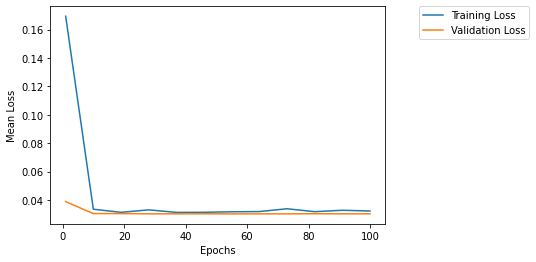

Spearman Correlation is:  0.15280530459202935


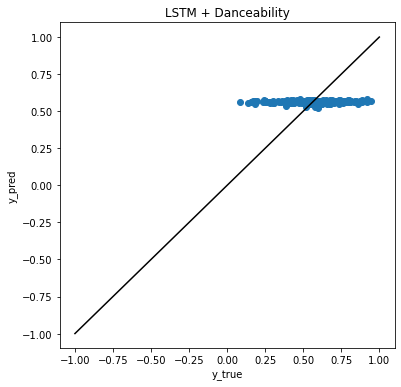

In [31]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model_8_6,"LSTM8.3",val_loader_3,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

## Step 9: Transfer Learning

In [13]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 50

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_loader))
input_shape = x_b1[0].shape


backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model9 = Classifier(NUM_CATEGORIES, backbone)
model9.load_state_dict(torch.load("CNN7"))
for weight in model9.parameters():
    weight.requires_grad = False
model9.output_layer=nn.Linear(1000,1)
model9.criterion=nn.MSELoss()
print(model9)
model9.to(DEVICE)
optimizer = torch.optim.Adam(model9.parameters(), lr=LR)
arr1,arr2=train(model9,"CNN9",train_loader_1, val_loader_1, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=True)


Classifier(
  (backbone): CNNBackbone(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss at training set: 1.0335496037170804
	Loss at validation set: 0.34930860570498873
Epoch 5/50, Loss at training set: 0.10150630258280656
	Loss at validation set: 0.10360367702586311
Epoch 10/50, Loss at training set: 0.09116964369755366
	Loss at validation set: 0.09386682723249708
Epoch 15/50, Loss at training set: 0.08951135570633001
	Loss at validation set: 0.09313668417079109
Epoch 20/50, Loss at training set: 0.08982781654801862
	Loss at validation set: 0.09140913720641818
Early Stopping was activated.
Epoch 24/50, Loss at training set: 0.08693995079475231
	Loss at validation set: 0.08936772069760732
Training has been completed.



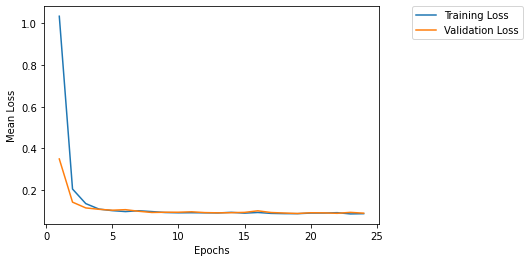

Spearman Correlation is:  -0.014448645249727426


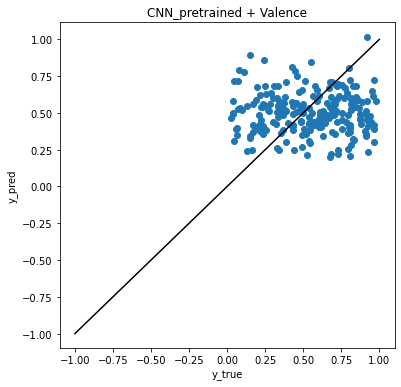

In [18]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,np.shape(arr1)[0],np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_2(model9,"CNN9",val_loader_1,crit=nn.MSELoss(),device=DEVICE,overfit_batch=False)

## Step 10: Multitask Learning

In [54]:
# HINT: Use this class mapping to merge similar classes and ignore classes that do not work very well
CLASS_MAPPING = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}


def torch_train_val_split(
    dataset, batch_train, batch_eval, val_size=0.2, shuffle=True, seed=420
):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_eval, sampler=val_sampler)
    return train_loader, val_loader


def read_spectrogram(spectrogram_file, chroma=True):
    # with open(spectrogram_file, "r") as f:
    spectrograms = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram
    # Decompose as follows
    return spectrograms.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1


class MultitaskDataset(Dataset):
    def __init__(
        self, path, class_mapping=None, train=True, max_length=-1, regression=True, 
    ):
        t = "train" if train else "test"
        p = os.path.join(path, t)
        self.regression = regression

        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            if not regression:
                self.labels = np.array(
                    self.label_transformer.fit_transform(labels)
                ).astype("int64")
            else:
                self.labels = np.array(labels).astype("float64")

    def get_files_labels(self, txt, class_mapping):
        with open(txt, "r") as fd:
            lines = [l.rstrip().split("\t") for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if self.regression:
                l = l[0].split(",")
                files.append(l[0] + ".fused.full.npy")
                labels.append([ float(l[1]), float(l[2]), float(l[3]) ])
                continue
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            fname = l[0]
            if fname.endswith(".gz"):
                fname = ".".join(fname.split(".")[:-1])
            files.append(fname)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)

class UnitedLoss(nn.Module):
    def forward(self, y_gold, y_pred):
        gold_valence = y_gold[:, 0]
        gold_energy  = y_gold[:, 1]
        gold_dance   = y_gold[:, 2]
        
        pred_valence = y_pred[:, 0]
        pred_energy  = y_pred[:, 1]
        pred_dance   = y_pred[:, 2]
        
        valence_loss = nn.MSELoss()(gold_valence, pred_valence)
        energy_loss  = nn.MSELoss()(gold_energy,  pred_energy)
        dance_loss   = nn.MSELoss()(gold_dance,   pred_dance)
        
        return valence_loss + energy_loss + dance_loss

def eval_3(model,model_name,dataloader, crit, device="cuda",overfit_batch=False):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.load_state_dict(torch.load(model_name))
#     print(model.parameters())
    criterion=crit
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):    
            if overfit_batch:
                inputs, labels, lengths = next(iter(dataloader))
            else:
                inputs, labels, lengths = batch
            loss, y_preds = model(inputs.float().to(device), labels.to(device), lengths.to(device))
            pred = y_preds
            y_pred.append(pred.cpu().numpy()) #get predicted labels
            y_act.append(labels.cpu().numpy()) #get real lables
    
    y_pred=np.array(y_pred)
    y_act=np.array(y_act)
    rho0= scipy.stats.spearmanr(np.array(y_act[:,0]).flatten(),np.array(y_pred[:,0]).flatten()).correlation
    rho1= scipy.stats.spearmanr(np.array(y_act[:,1]).flatten(),np.array(y_pred[:,1]).flatten()).correlation
    rho2= scipy.stats.spearmanr(np.array(y_act[:,2]).flatten(),np.array(y_pred[:,2]).flatten()).correlation
    mean=(rho0+rho1+rho2)/3
    print("Spearman Correlations are: ",rho0, " ", rho1, " ",rho2)
    print("Mean is: ", mean)

    golden_line = np.linspace(-1,1,1000)
    # For valence
    figure, axis = plt.subplots(1, 3,figsize=(10, 10))
    axis[0].scatter(np.array(y_act[:,0]).flatten(), np.array(y_pred[:,0]).flatten())
    axis[0].plot(golden_line,golden_line, '-', color='k')
    axis[0].set_title("Valence")
    axis[0].set_xlabel("y_true")
    axis[0].set_ylabel("y_pred")
    # For energy
    axis[1].scatter(np.array(y_act[:,1]).flatten(), np.array(y_pred[:,1]).flatten())
    axis[1].plot(golden_line,golden_line, '-', color='k')
    axis[1].set_title("Energy")
    axis[1].set_xlabel("y_true")
    axis[1].set_ylabel("y_pred")
    # For danceability
    axis[2].scatter(np.array(y_act[:,2]).flatten(), np.array(y_pred[:,2]).flatten())
    axis[2].plot(golden_line,golden_line, '-', color='k')
    axis[2].set_title("Danceability")
    axis[2].set_xlabel("y_true")
    axis[2].set_ylabel("y_pred")

    figure.show() 

    return mean

In [33]:
BATCH_SIZE = 32
MAX_LENGTH = -1
DEVICE = 'cuda'

PARENT_DATA_DIR = '../input/patreco3-multitask-affective-music/data/'

train_dataset_10=MultitaskDataset(
    os.path.join(PARENT_DATA_DIR, 'multitask_dataset'), class_mapping=CLASS_MAPPING, 
    train=True, max_length=MAX_LENGTH, regression=True,
)

train_loader_10,val_loader_10 = torch_train_val_split(
    train_dataset_10, BATCH_SIZE, BATCH_SIZE )






In [34]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

DEVICE = 'cuda'
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000

LR = 1e-4
epochs = 50

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_loader_10))
input_shape = x_b1[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model10 = Classifier(NUM_CATEGORIES, backbone)
model10.output_layer=nn.Linear(1000,3)
model10.criterion=UnitedLoss()
optimizer = torch.optim.Adam(model10.parameters(), lr=LR)
# print(model10)
model10.to(DEVICE)
#also quest_nine=True
arr1,arr2=train(model10,"CNN10",train_loader_10, val_loader_10, optimizer, epochs, device=DEVICE, overfit_batch=False,quest_nine=True)

Training started for model checkpoint...
Epoch 1/50, Loss at training set: 3302.55147266799
	Loss at validation set: 40.23409216744559
Epoch 5/50, Loss at training set: 0.6060723518503124
	Loss at validation set: 0.43970942071505953
Epoch 10/50, Loss at training set: 0.2943402970659322
	Loss at validation set: 0.23664564958640508
Epoch 15/50, Loss at training set: 0.17549914738227582
	Loss at validation set: 0.17199432849884033
Epoch 20/50, Loss at training set: 0.13915262448376622
	Loss at validation set: 0.16580120580536978
Epoch 25/50, Loss at training set: 0.10195703149355691
	Loss at validation set: 0.18344474477427347
Early Stopping was activated.
Epoch 29/50, Loss at training set: 0.09029694595213594
	Loss at validation set: 0.1622602939605713
Training has been completed.



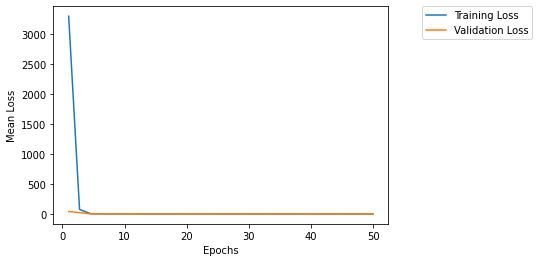

Spearman Correlations are:  0.5579733974048451   0.6584415584415585   0.5220779220779221
Mean is:  0.5794976259747753


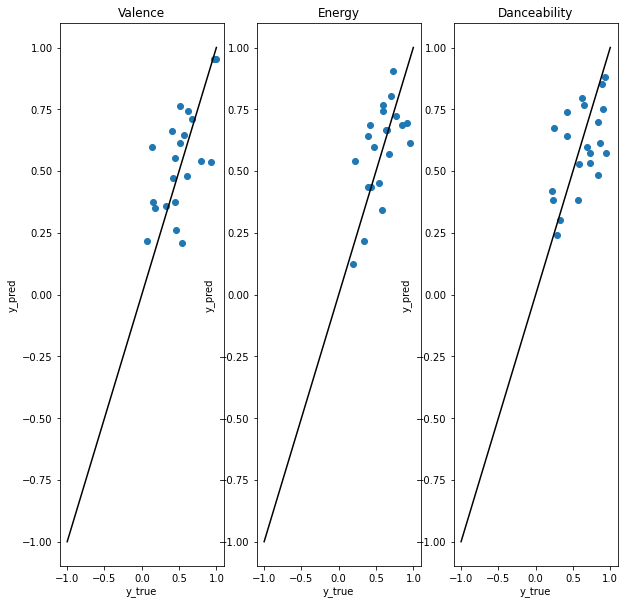

In [55]:
import matplotlib.pyplot as plt
import scipy
epochs_=np.linspace(1,epochs,np.shape(arr1)[0])
plt.plot(epochs_,arr1,label='Training Loss')
plt.plot(epochs_,arr2,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)
plt.show()
a1=eval_3(model10,"CNN10",val_loader_10,crit=UnitedLoss(),device=DEVICE,overfit_batch=False)